# Section 1

Analyses for Section 1 of the Manuscript.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from NegativeClassOptimization import utils, preprocessing, ml, config, datasets, visualisations

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
base_p = Path(config.DATA_BASE_PATH) / "Frozen_MiniAbsolut_ML_x10under"
df = pd.read_csv(base_p / "closed_performance.tsv", sep='\t')
df.head()

,task,N_pos,N_neg,acc,recall,precision,f1
0,HIGH_VS_95LOW__3VRL__auto__0__42,513,487,0.989000,0.994152,0.984556,0.989331
1,HIGH_VS_LOOSER__3VRL__auto__0__42,513,487,0.894000,0.886940,0.904573,0.895669
2,ONE_VS_NINE__3VRL__auto__0__42,503,496,0.935936,0.940358,0.932939,0.936634
3,HIGH_VS_95LOW__3VRL__auto__1__42,513,487,0.989000,0.994152,0.984556,0.989331
4,HIGH_VS_LOOSER__3VRL__auto__1__42,513,487,0.903000,0.896686,0.912698,0.904621


In [3]:
records = []
for i, row in df.iterrows():
    task_str = row["task"]
    task = datasets.ClassificationTask.init_from_str(task_str)
    records.append({
        "task": task_str,
        "ag_pos": task.ag_pos,
        "ag_neg": task.ag_neg,
        "seed_id": task.seed_id,
        "split_id": task.split_id,
        "task_type": task.task_type.to_str(),
    })

df = pd.merge(df, pd.DataFrame(records), on="task")
df = df.loc[~((df["ag_pos"] == "HR2B") | (df["ag_neg"] == "HR2B"))].copy()

map_task_type_to_clean = visualisations.PlotParams.map_task_type_to_clean.copy()
df["task_type_clean"] = df["task_type"].map(map_task_type_to_clean)
df["acc_closed"] = df["acc"].astype(float)

print(df.shape)
df.head(10)

(270, 14)


,task,N_pos,N_neg,acc,recall,precision,f1,ag_pos,ag_neg,seed_id,split_id,task_type,task_type_clean,acc_closed
0,HIGH_VS_95LOW__3VRL__auto__0__42,513,487,0.989000,0.994152,0.984556,0.989331,3VRL,auto,0,42,high_vs_95low,vs Non-binder,0.989000
1,HIGH_VS_LOOSER__3VRL__auto__0__42,513,487,0.894000,0.886940,0.904573,0.895669,3VRL,auto,0,42,high_vs_looser,vs Weak,0.894000
2,ONE_VS_NINE__3VRL__auto__0__42,503,496,0.935936,0.940358,0.932939,0.936634,3VRL,auto,0,42,1v9,vs 9,0.935936
3,HIGH_VS_95LOW__3VRL__auto__1__42,513,487,0.989000,0.994152,0.984556,0.989331,3VRL,auto,1,42,high_vs_95low,vs Non-binder,0.989000
4,HIGH_VS_LOOSER__3VRL__auto__1__42,513,487,0.903000,0.896686,0.912698,0.904621,3VRL,auto,1,42,high_vs_looser,vs Weak,0.903000
5,ONE_VS_NINE__3VRL__auto__1__42,503,496,0.929930,0.942346,0.920388,0.931238,3VRL,auto,1,42,1v9,vs 9,0.929930
6,HIGH_VS_95LOW__3VRL__auto__2__42,513,487,0.989000,0.994152,0.984556,0.989331,3VRL,auto,2,42,high_vs_95low,vs Non-binder,0.989000
7,HIGH_VS_LOOSER__3VRL__auto__2__42,513,487,0.898000,0.892788,0.906931,0.899804,3VRL,auto,2,42,high_vs_looser,vs Weak,0.898000
8,ONE_VS_NINE__3VRL__auto__2__42,503,496,0.927928,0.942346,0.916828,0.929412,3VRL,auto,2,42,1v9,vs 9,0.927928
9,HIGH_VS_95LOW__3VRL__auto__3__42,513,487,0.989000,0.994152,0.984556,0.989331,3VRL,auto,3,42,high_vs_95low,vs Non-binder,0.989000


## vs Non-binder, vs Weak, vs 1, vs 9 performances

In [4]:
# Get order of antigens by high_vs_looser performance
ag_order = df.loc[df["task_type"] == "high_vs_looser"].groupby("ag_pos")["acc_closed"].mean().sort_values(ascending=False).index.to_list()

In [5]:
task_order = ["high_vs_95low", "1v9", "high_vs_looser"]

map_task_type_to_clean = visualisations.PlotParams.map_task_type_to_clean.copy()
task_clean_order = [map_task_type_to_clean[x] for x in task_order]

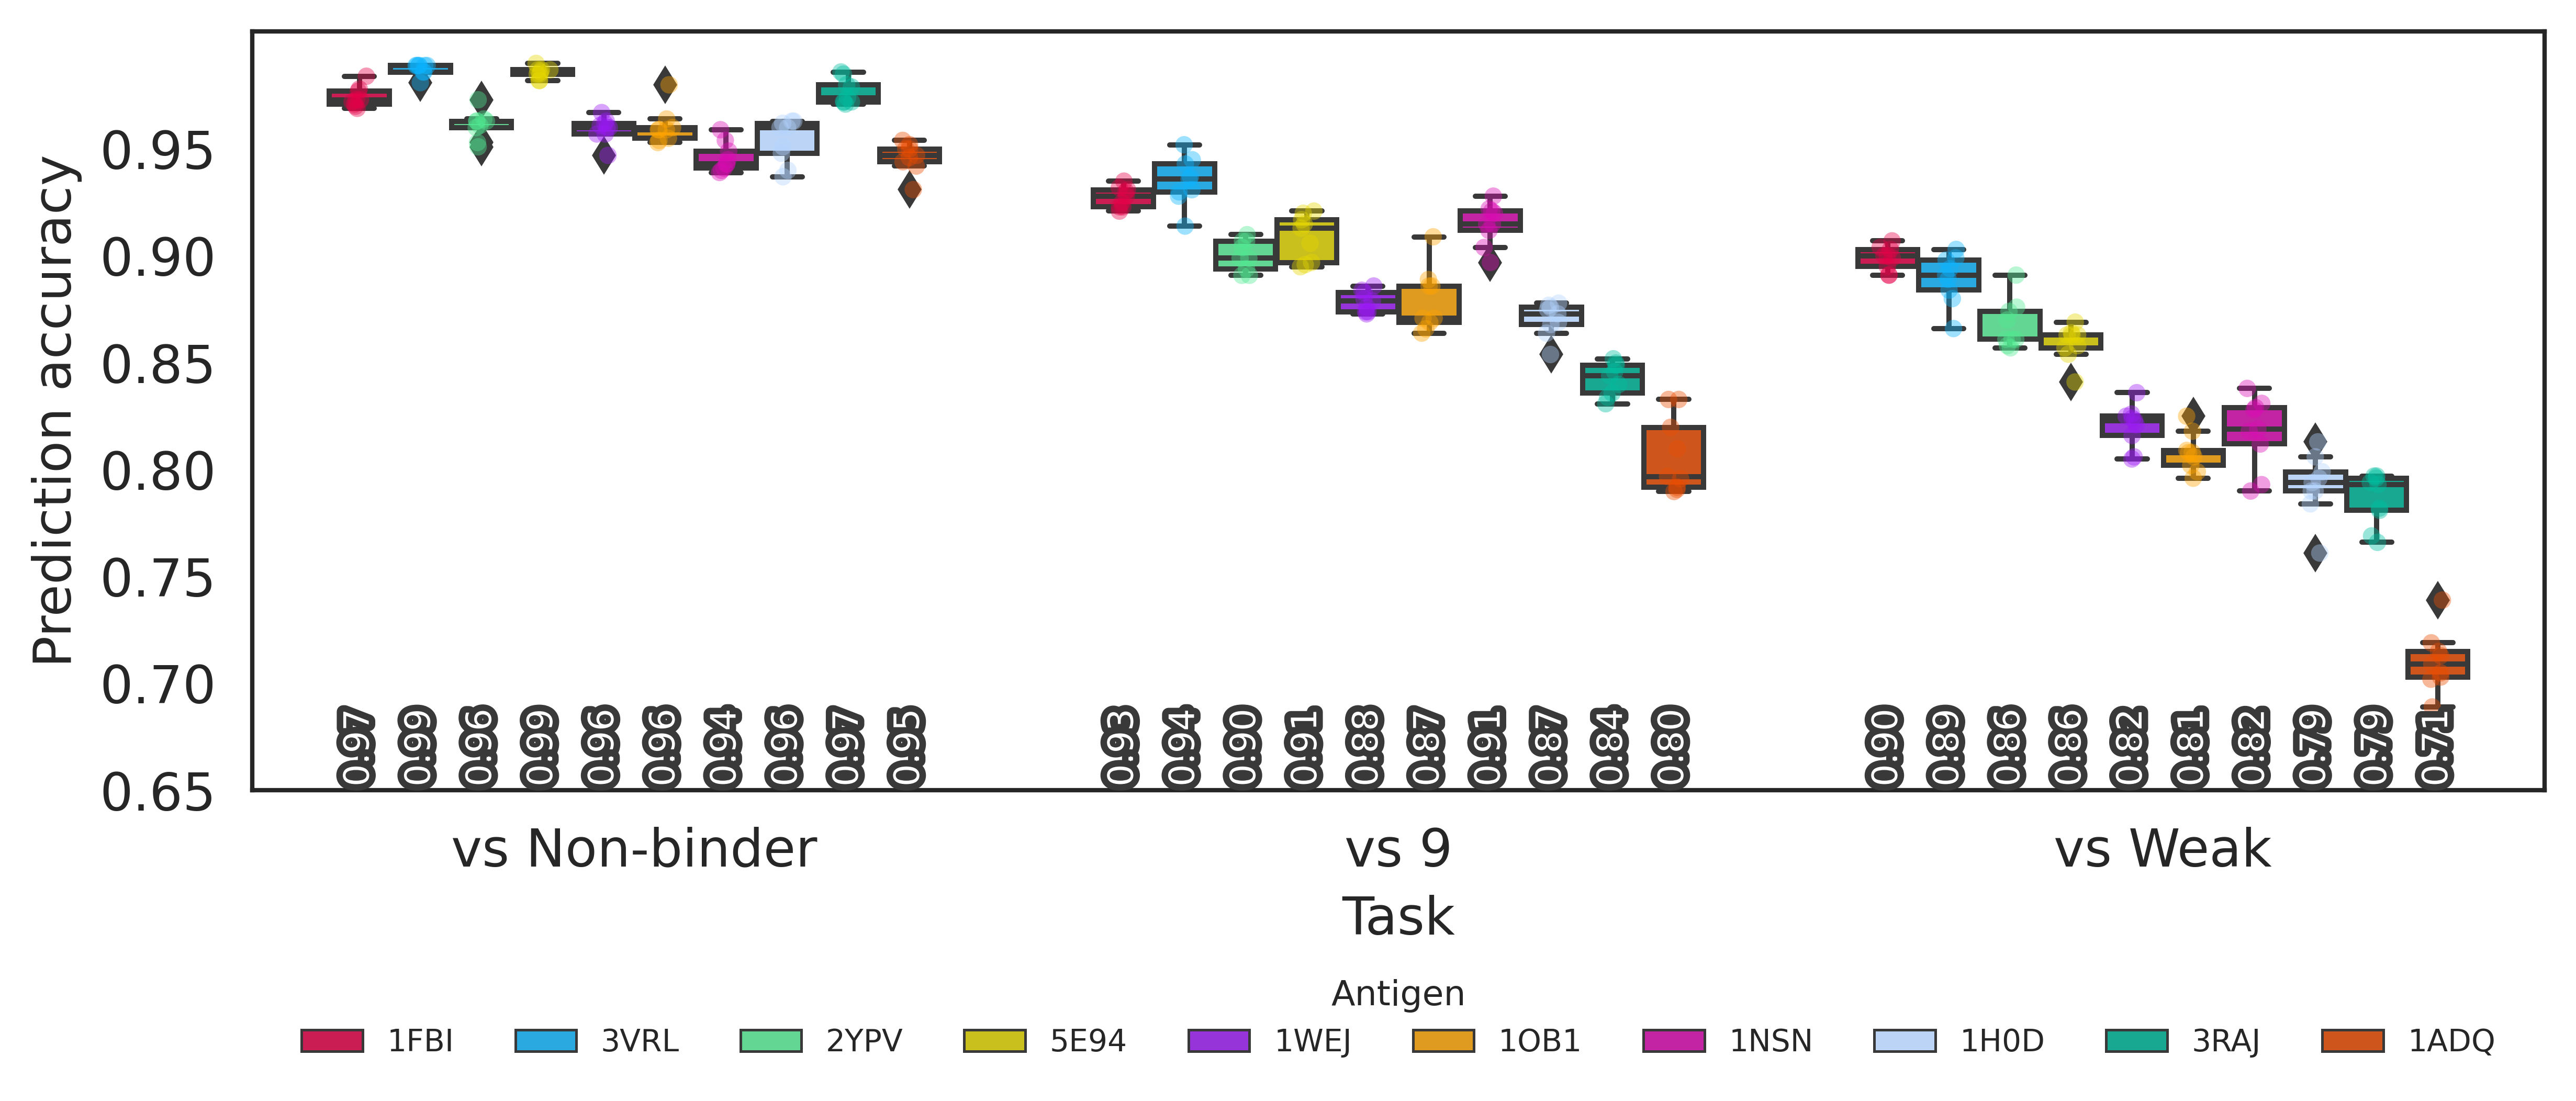

In [6]:
yticks = np.arange(0.65, 1.0, 0.05)
yaxis_title = "Prediction accuracy"
ag_order = visualisations.PlotParams.order_antigens
# task_order = visualisations.PlotParams.order_tasks
# task_clean_order = visualisations.PlotParams.order_tasks_clean
cmap = visualisations.PlotParams.cmap_antigens

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)

# Transparent boxplot
sns.boxplot(
    x="task_type_clean",
    y="acc_closed",
    hue="ag_pos",
    data=df,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=cmap,
    boxprops=dict(alpha=1),
)
# Add data points on top of boxplot in low transparency
sns.stripplot(
    x="task_type_clean",
    y="acc_closed",
    hue="ag_pos",
    data=df,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=cmap,
    alpha=0.4,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

visualisations.add_median_labels(ax, y_level=0.67, fontsize=8)

ax.tick_params(labelsize=12)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Antigen",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Task", fontsize=12)
ax.set_ylabel(yaxis_title, fontsize=12)
ax.set_yticks(yticks)

fig.show()

In [7]:
df.groupby("task_type")["acc_closed"].agg(["median", "std"])

,median,std
task_type,,
1v9,0.890891,0.039180
high_vs_95low,0.963000,0.015662
high_vs_looser,0.823500,0.054948


/tmp/ipykernel_185984/1086611567.py:9: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.stripplot(


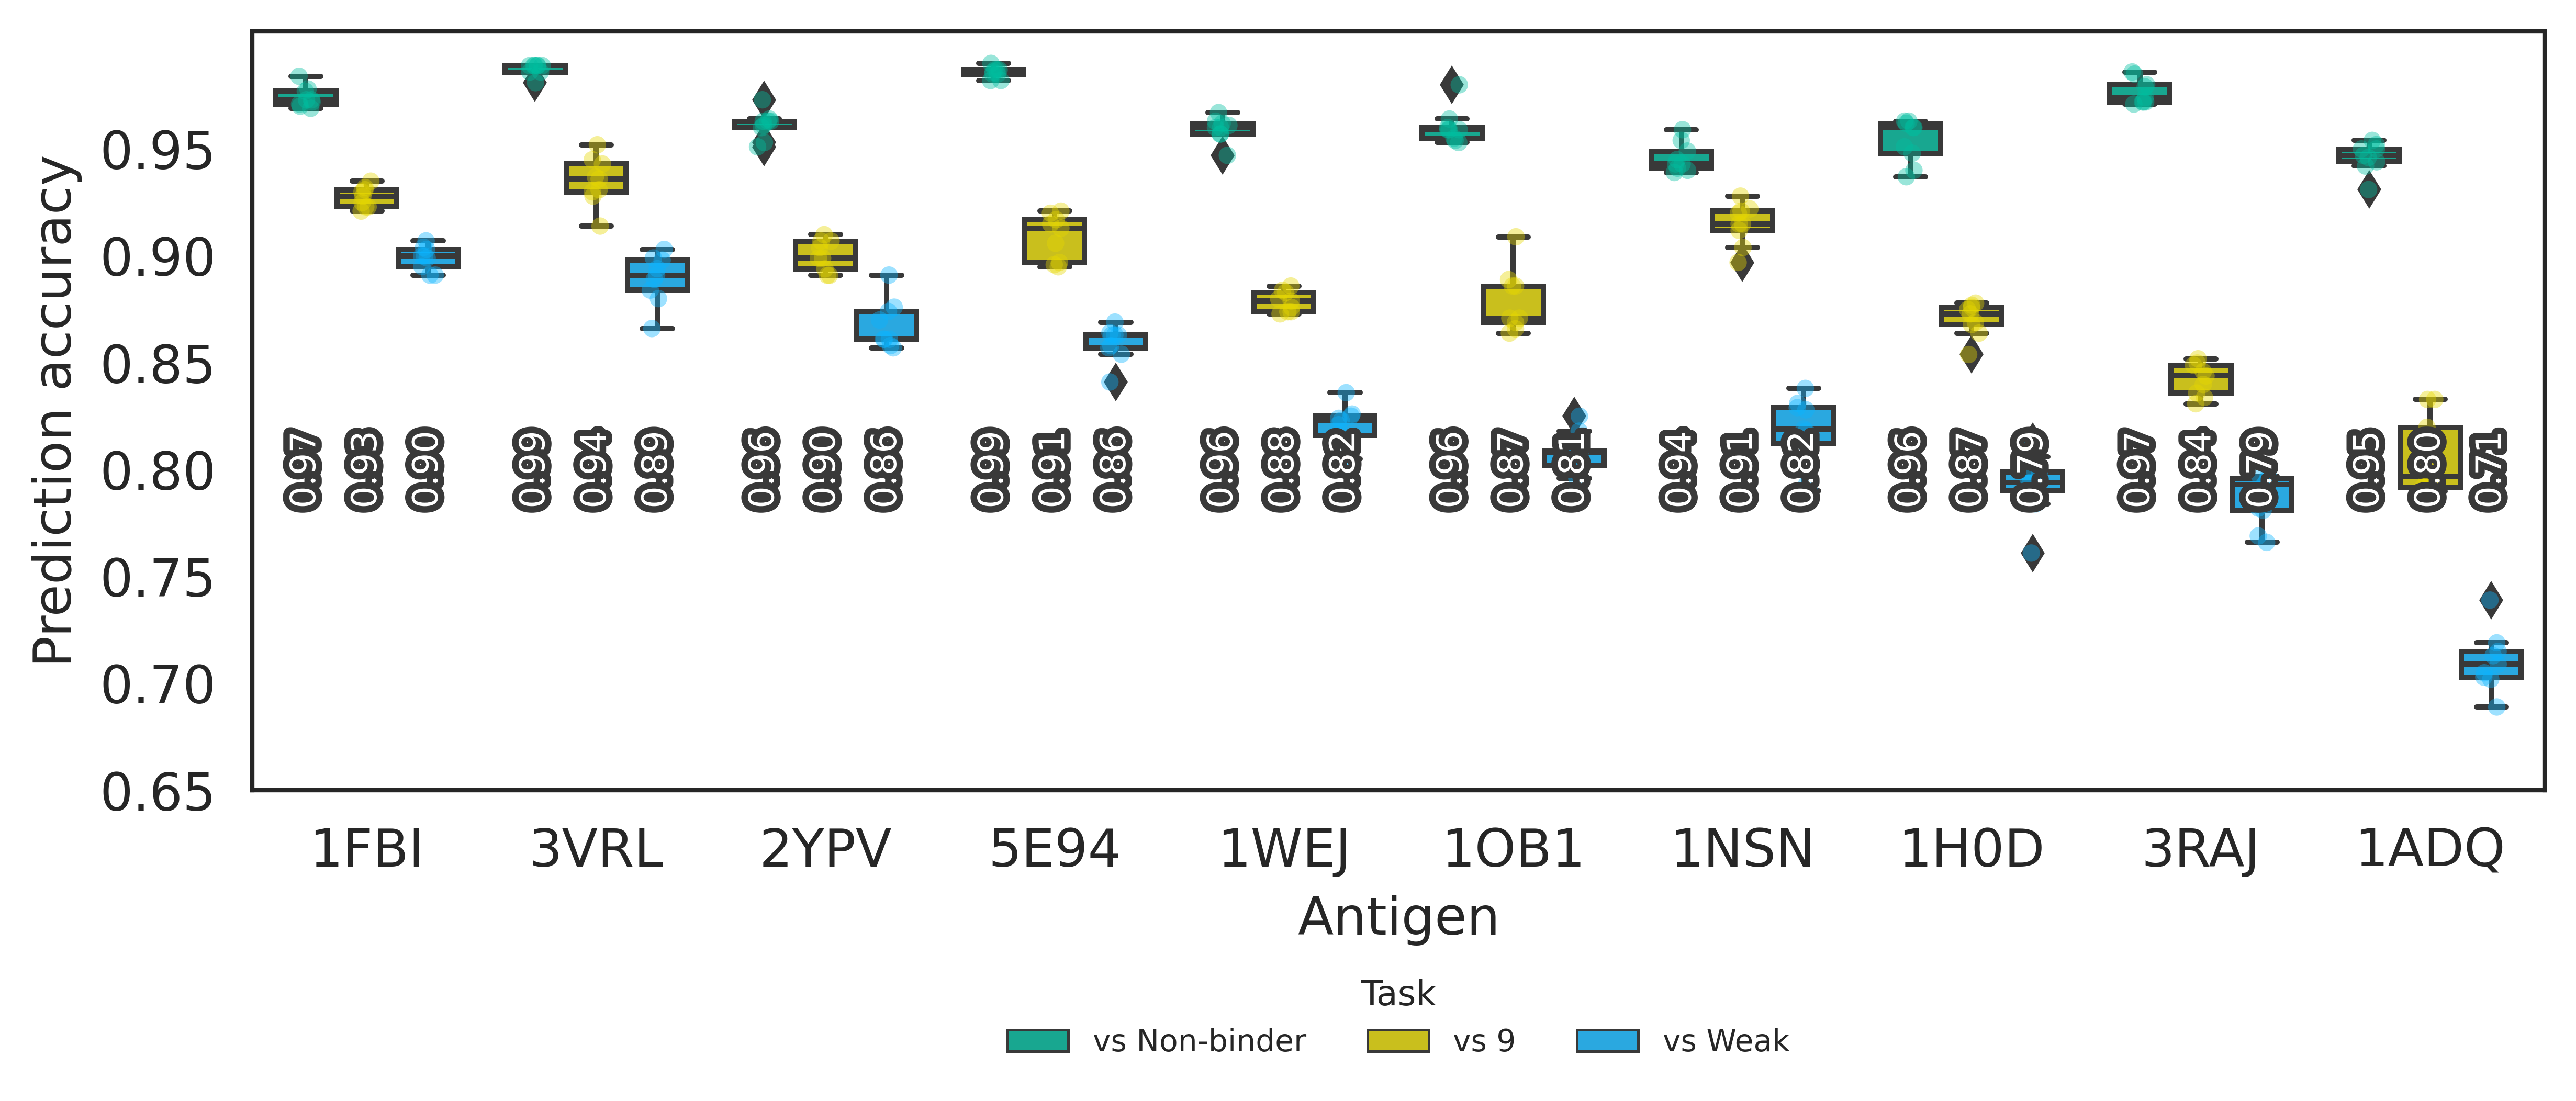

In [8]:
cmap = visualisations.PlotParams.cmap_tasks

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)


## Add data points on top of boxplot in low transparency
sns.stripplot(
    x="ag_pos",
    y="acc_closed",
    hue="task_type_clean",
    data=df,
    ax=ax,
    # Order on x axis
    order=ag_order,
    hue_order=map(lambda x: map_task_type_to_clean[x], ["high_vs_95low", "1v9", "high_vs_looser"]),
    # palette="Set2",
    palette=cmap,
    alpha=0.4,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

sns.boxplot(
    x="ag_pos",
    y="acc_closed",
    hue="task_type_clean",
    data=df,
    ax=ax,
    order=ag_order,
    boxprops=dict(alpha=1),  # a better solution is below
    hue_order=map(lambda x: map_task_type_to_clean[x], ["high_vs_95low", "1v9", "high_vs_looser"]),
    palette=cmap,
)
## Based on https://github.com/mwaskom/seaborn/issues/979#issuecomment-235082271
for patch in ax.artists:
    fc = patch.get_facecolor()
    patch.set_facecolor(mpl.colors.to_rgba(fc, 0.1))


visualisations.add_median_labels(ax, y_level=0.8, fontsize=8)


FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)

ax.set_xlabel("Antigen", fontsize=FONT_SIZE)
ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)

ax.set_yticks(yticks)
# Add legend under the plot, under x axis label
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

fig.show()

In [9]:
df.groupby("ag_pos")["acc_closed"].agg(["median", "std"]).sort_values("median", ascending=False)

,median,std
ag_pos,,
3VRL,0.935936,0.041821
1FBI,0.927928,0.031966
1NSN,0.914915,0.056846
5E94,0.912913,0.053587
2YPV,0.898899,0.040364
1WEJ,0.878879,0.058519
1H0D,0.872873,0.067953
1OB1,0.870871,0.064345
3RAJ,0.843844,0.081974


## OOD

In [10]:
df_o = pd.read_csv(base_p / "openset_performance.tsv", sep="\t")
df_o["ag"] = df_o["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).ag_pos)
df_o["task_1_type"] = df_o["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())
df_o["task_2_type"] = df_o["task_2"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())
def get_replicate_id(task_str):
    task = datasets.ClassificationTask.init_from_str(task_str)
    return str(task.seed_id) + "_" + str(task.split_id)
df_o["replicate_id"] = df_o["task_1"].apply(get_replicate_id)

print(df_o.shape)
df_o.head()

(7290, 10)


,task_1,task_2,acc,recall,precision,f1,ag,task_1_type,task_2_type,replicate_id
0,HIGH_VS_95LOW__3VRL__auto__0__42,HIGH_VS_95LOW__3VRL__auto__0__42,0.989000,0.994152,0.984556,0.989331,3VRL,high_vs_95low,high_vs_95low,0_42
1,HIGH_VS_95LOW__3VRL__auto__0__42,HIGH_VS_LOOSER__3VRL__auto__0__42,0.652000,0.994152,0.596491,0.745614,3VRL,high_vs_95low,high_vs_looser,0_42
2,HIGH_VS_95LOW__3VRL__auto__0__42,ONE_VS_NINE__3VRL__auto__0__42,0.836837,0.994036,0.757576,0.859845,3VRL,high_vs_95low,1v9,0_42
3,HIGH_VS_95LOW__3VRL__auto__0__42,HIGH_VS_95LOW__3VRL__auto__1__42,0.989000,0.994152,0.984556,0.989331,3VRL,high_vs_95low,high_vs_95low,0_42
4,HIGH_VS_95LOW__3VRL__auto__0__42,HIGH_VS_LOOSER__3VRL__auto__1__42,0.652000,0.994152,0.596491,0.745614,3VRL,high_vs_95low,high_vs_looser,0_42


In [11]:
df_o_all = df_o.copy()
df_o = df_o.query("task_1_type != '1v1' and task_2_type != '1v1'").copy()

In [12]:
df_o["model_task"] = df_o["task_1_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])
df_o["test_task"] = df_o["task_2_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])

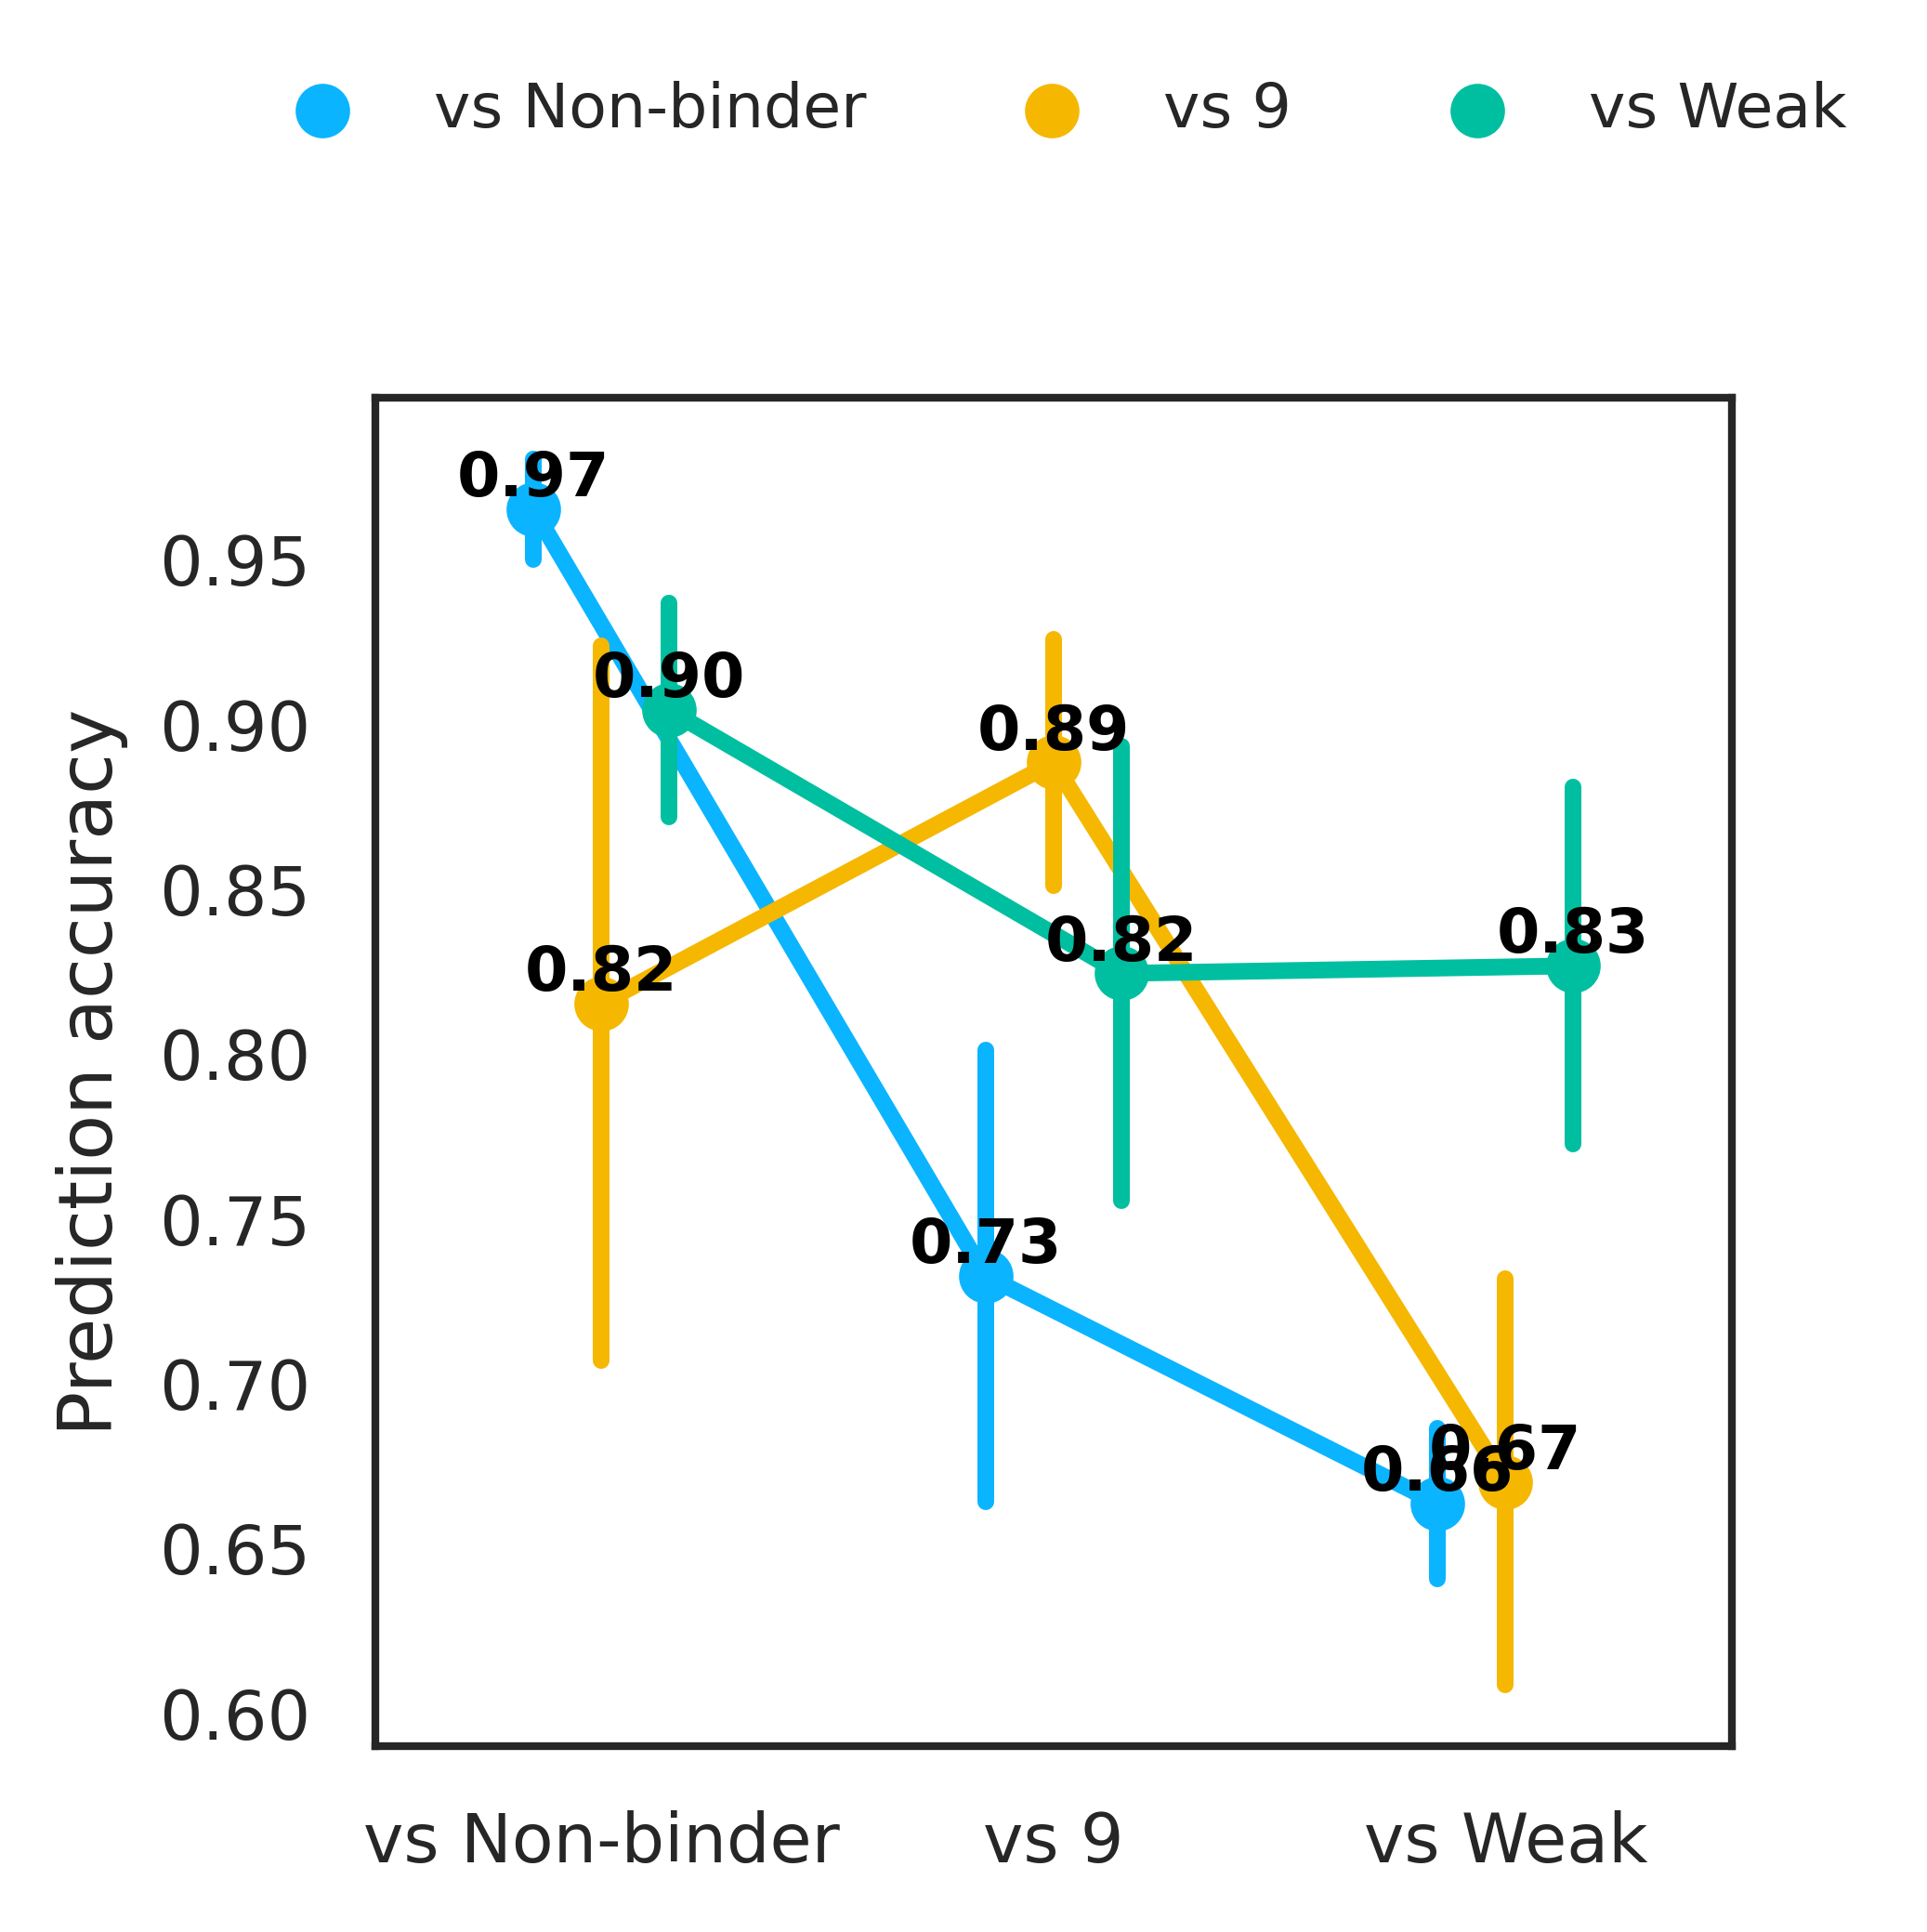

In [13]:
cmap = [
    # Selection from Dutch Field
    "#0bb4ff",  # Blue
    "#f5b700",  # Yellow
    "#00bfa0",  # Dark Green
    # "#e60049",  # Red
]

# order_tasks_nonclean = ["high_vs_95low", "high_vs_looser", "high_vs_randseq", "high_vs_randpos"]
order_tasks_nonclean = ["high_vs_95low", "1v9", "high_vs_looser"]
task_order = list(map(lambda x: map_task_type_to_clean[x], order_tasks_nonclean))

order_antigens = df_o["ag"].value_counts().index.to_list()


fig, ax = plt.subplots(figsize=(1* 3.14, 1 * 3.14), dpi=600)
sns.pointplot(
    df_o,
    y="acc",
    x="test_task",
    errorbar="sd",
    order=task_order,
    hue="model_task",
    hue_order=task_order,
    palette=cmap,
    # Spread out the points a bit in horizontal
    dodge=0.3,
    ax=ax,
)

# Add legend horizontally on top of plot area, outside plot area
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    # title_fontsize=8,
)

ax.set_xlabel(None)
ax.set_ylabel("Prediction accuracy")

# Add text
for i, col in enumerate(ax.collections):
    for j, txt in enumerate(col.get_offsets()[:, 0]):
        ax.text(
            txt,
            col.get_offsets()[j, 1],
            f"{col.get_offsets()[j, 1]:.2f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=8,
            fontweight="bold",
        )

fig.show()

Check for results for the randomized sequences in HR2P

In [14]:
raise ValueError("Stop here, below draft for ood per antigen, not functional yet.")

ValueError: Stop here, below draft for ood per antigen, not functional yet.

In [ ]:
# df_o_all["model_task"] = df_o_all["task_1_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])
# df_o_all["test_task"] = df_o_all["task_2_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])

In [ ]:
# cmap = [
#     # Selection from Dutch Field
#     "#0bb4ff",  # Blue
#     "#f5b700",  # Yellow
#     "#00bfa0",  # Dark Green
#     # "#e60049",  # Red
# ]
# fig, ax = plt.subplots(figsize=(2.5 * 3.14, 1.4 * 3.14), dpi=600)

# # order_tasks_nonclean = ["high_vs_95low", "high_vs_looser", "high_vs_randseq", "high_vs_randpos"]
# order_tasks_nonclean = ["high_vs_95low", "high_vs_looser", "1v9"]
# task_order = list(map(lambda x: map_task_type_to_clean[x], order_tasks_nonclean))

# order_antigens = df_o_all["ag"].value_counts().index.to_list()

# for i, ag in enumerate(order_antigens):
#     row = 0
#     col = i
#     ax = axs
#     df_i = df_o_all.query("ag == @ag")
#     sns.pointplot(
#         df_i,
#         x="test_task",
#         y="acc",
#         order=task_order,
#         hue="model_task",
#         hue_order=task_order,
#         errorbar="sd",
#         # palette=visualisations.PlotParams.cmap_tasks_no1v1,
#         palette=cmap,
#         ax=ax,
#     )

#     ax.legend().remove()

#     ax.set_xlabel(None)
#     if row == 0:
#         ax.set_xticks([])
#     elif row == 1:
#         for tick in ax.get_xticklabels():
#             # tick.set_rotation(45)
#             # 45 degree rotation, but with the text centered
#             tick.set_rotation(45)
#             tick.set_horizontalalignment("right")

#     ax.set_ylim(0.25, 1.0)
#     ax.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
#     if col == 0:
#         ax.set_ylabel("Prediction accuracy", fontsize=8)
#     else:
#         ax.set_yticklabels([])
#         ax.set_ylabel(None)

#     ax.set_xlabel(task_order)
#     ax.set_title(f"{ag}", fontsize=8)
#     ax.tick_params(axis="both", which="major", labelsize=8)

# # Add table
# loc = "lower right"
# table_values = (
#     df_o.groupby(["model_task", "test_task"])["acc"]
#     .median()
#     .reset_index()
#     .pivot(index="model_task", columns="test_task", values="acc")
#     .loc[task_order][task_order]
#     .values * 100).round().astype(int)
# # table_values = np.where(table_values == 100, "", table_values)
# ax.table(
#     cellText=table_values,
#     loc=loc,
#     cellLoc="center",
#     colWidths=[0.08, 0.08, 0.08],
#     cellColours=np.array([cmap for _ in range(3)]).transpose(),
# )

# # Add one legend horizontal above all subplots, as part of figure
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(
#     handles,
#     labels,
#     loc="upper center",
#     ncol=5,
#     fontsize=8,
#     frameon=False,
#     # title="Model trained on",
#     title_fontsize=8,
# )

# fig.show()